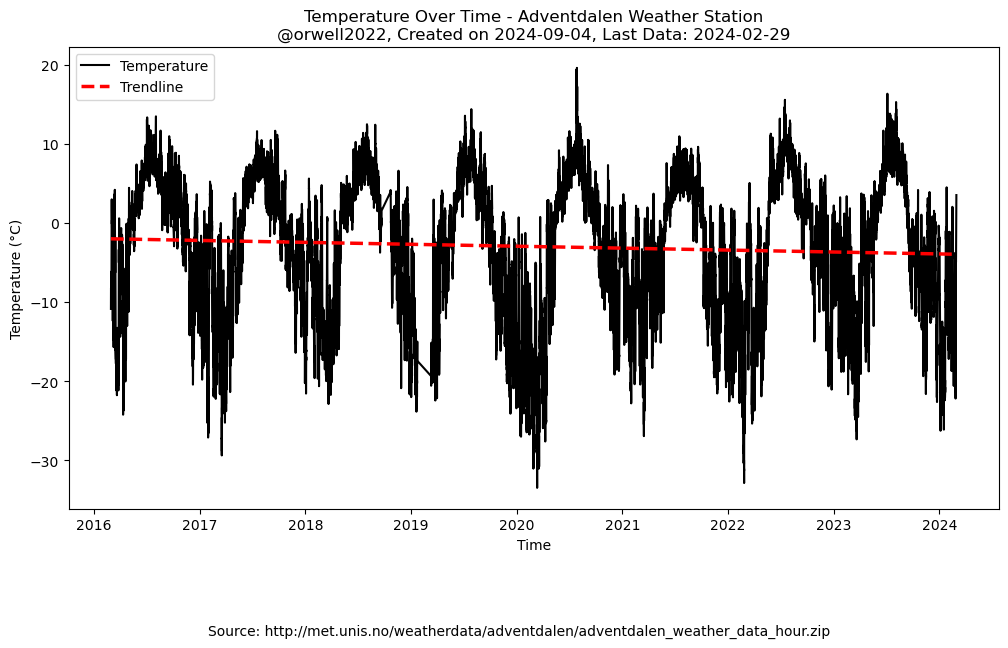

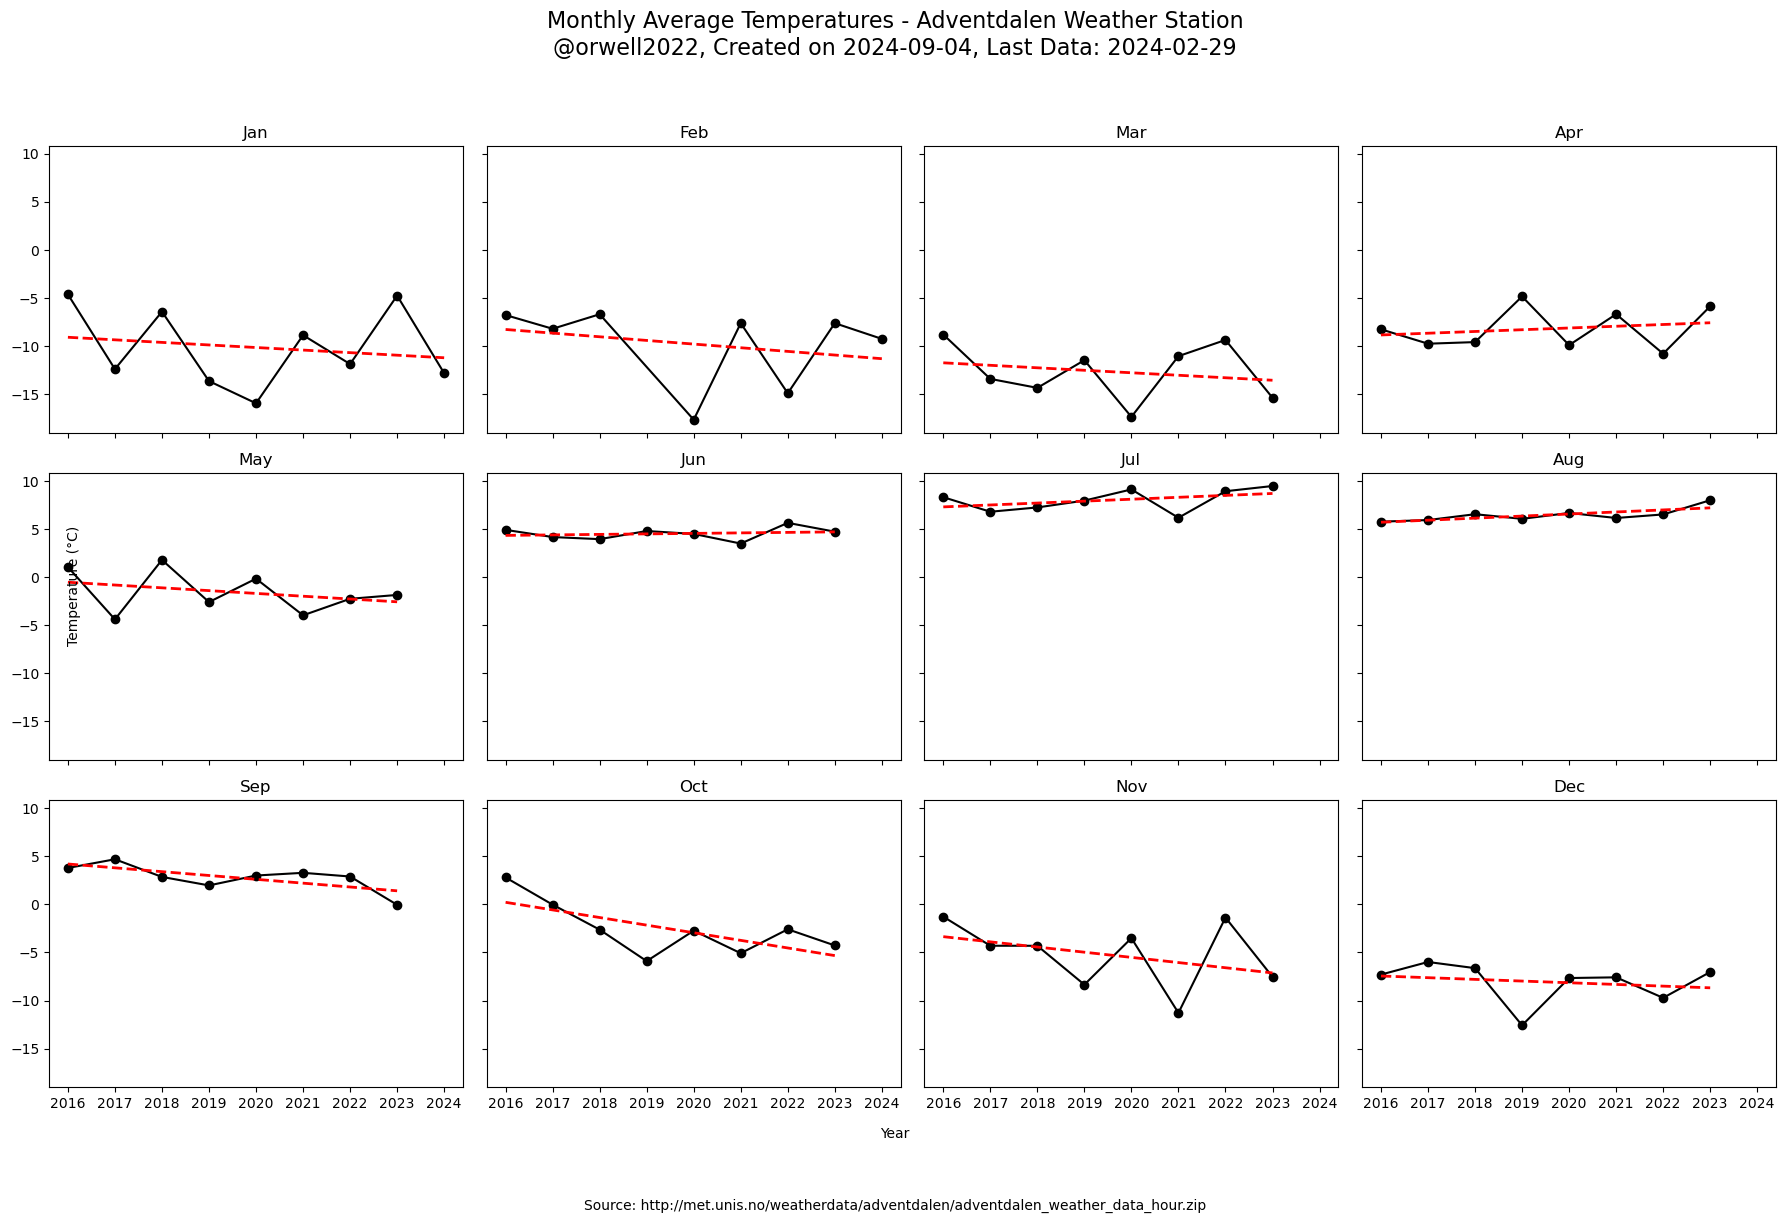

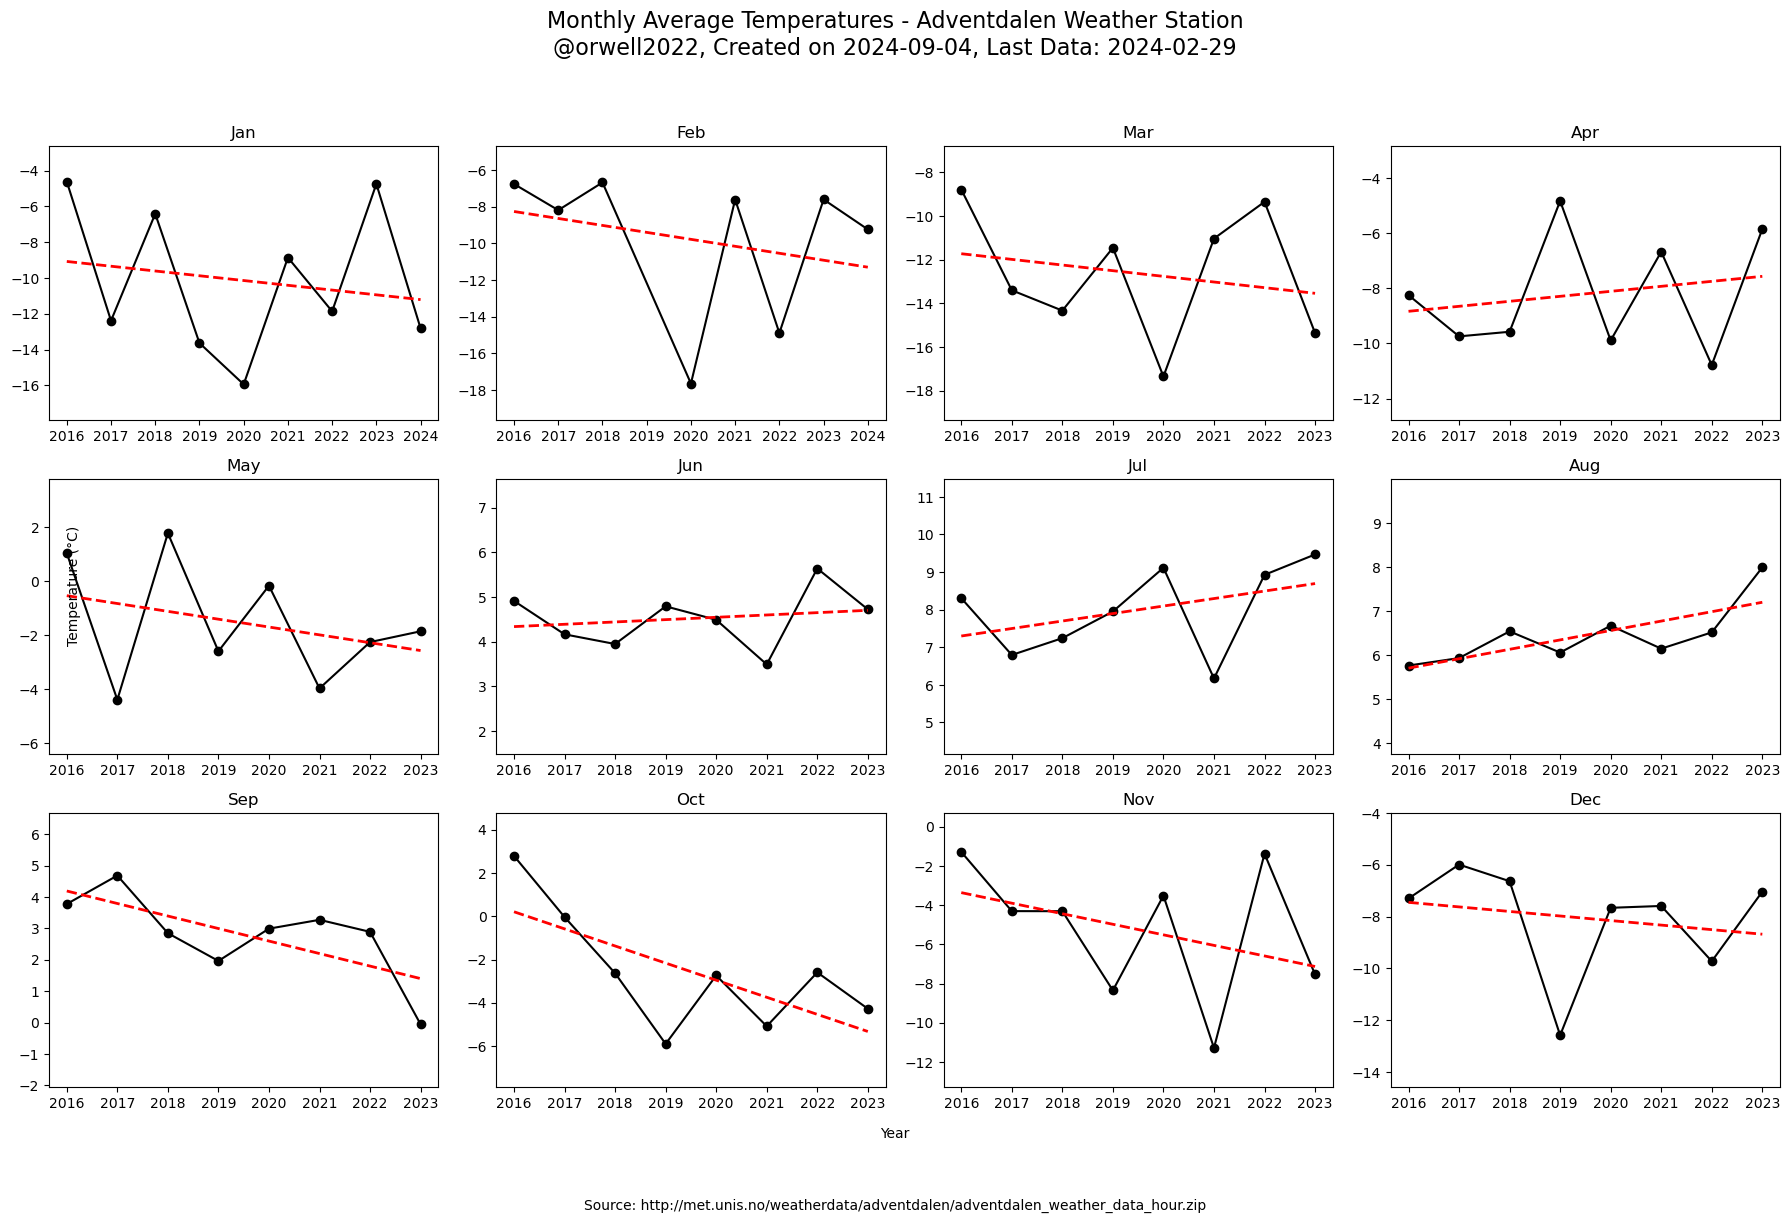

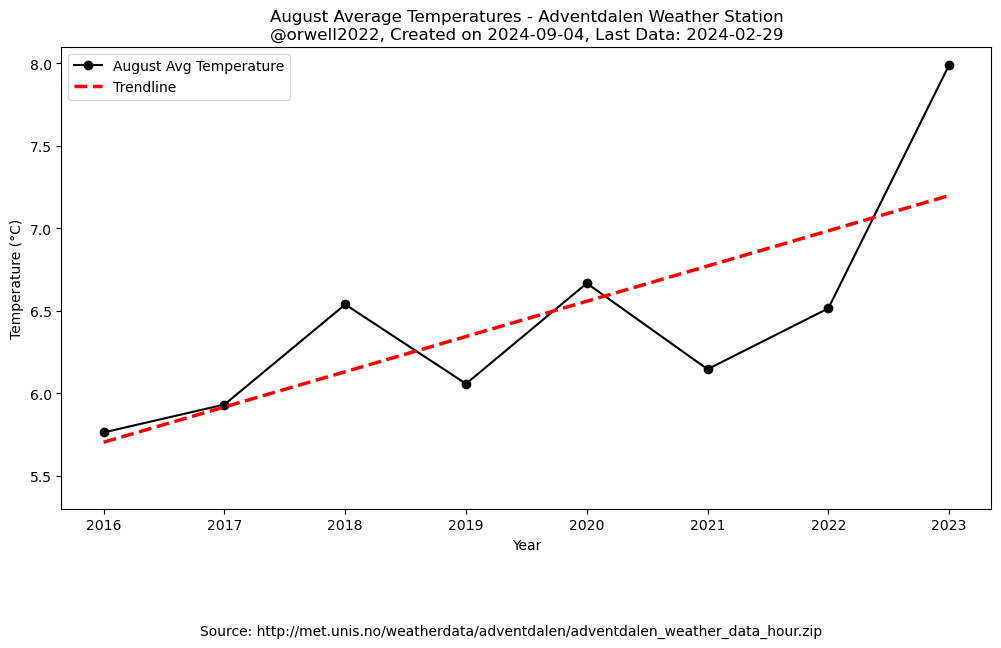

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile, io

# Step 1: Download and unzip the data
url = "http://met.unis.no/weatherdata/adventdalen/adventdalen_weather_data_hour.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("adventdalen_data")

# Step 2: Load the data
file_path = "adventdalen_data/Adventdalen_Hour.dat"
data = pd.read_csv(file_path, delimiter=',', skiprows=4)

# Step 3: Define columns based on typical weather station data
columns = [
    'TIMESTAMP', 'RECORD', 'ID', 'LT1_gr_C_Max', 'LT1_gr_C_Min', 'LT1_gr_C_Avg',
    'LT2_gr_C_Max', 'LT2_gr_C_Min', 'LT2_gr_C_Avg', 'LT3_gr_C_Max', 'LT3_gr_C_Min',
    'LT3_gr_C_Avg', 'RH_Max', 'RH_Min', 'RH_Avg', 'WS_Max', 'WS_Min', 'WS_Avg',
    'WD_Max', 'WD_Min', 'Pressure', 'Rain_Total', 'Rain_Incremental', 'SR_Max', 
    'SR_Avg', 'WindChill_Max', 'WindChill_Min', 'WindChill_Avg', 'Battery_Voltage'
]

# Renaming the columns
data.columns = columns

# Convert the TIMESTAMP column to datetime
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Create additional columns for year and month
data['Year'] = data['TIMESTAMP'].dt.year
data['Month'] = data['TIMESTAMP'].dt.month

# Step 4: Plot 1 - Overall data with a trendline, ensuring the start and end dates align

# Determine the first date aligned with the last date
last_date = data['TIMESTAMP'].max()
first_date = data[data['TIMESTAMP'].dt.year == data['TIMESTAMP'].dt.year.min()]['TIMESTAMP'].min().replace(month=last_date.month, day=last_date.day)

# Filter the data to match this date range
filtered_data = data[(data['TIMESTAMP'] >= first_date) & (data['TIMESTAMP'] <= last_date)]

plt.figure(figsize=(12, 6))
plt.plot(filtered_data['TIMESTAMP'], filtered_data['LT1_gr_C_Avg'], label='Temperature', color='black')

# Calculate and plot the trendline for overall data
z_overall = np.polyfit(pd.to_numeric(filtered_data['TIMESTAMP']), filtered_data['LT1_gr_C_Avg'], 1)
p_overall = np.poly1d(z_overall)
plt.plot(filtered_data['TIMESTAMP'], p_overall(pd.to_numeric(filtered_data['TIMESTAMP'])), "r--", linewidth=2.5, label='Trendline')

# Adding labels and title
station_name = "Adventdalen Weather Station"
creation_date = pd.Timestamp.today().strftime('%Y-%m-%d')
last_data_day = last_date.strftime('%Y-%m-%d')

plt.title(f'Temperature Over Time - {station_name}\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time')

# Adding source as footnote
plt.figtext(0.5, -0.1, 'Source: http://met.unis.no/weatherdata/adventdalen/adventdalen_weather_data_hour.zip', 
            wrap=True, horizontalalignment='center', fontsize=10)

# Displaying the plot
plt.legend()
plt.show()

# Step 5: Plot 2 - 3x4 grid of monthly average temperatures with uniform range

monthly_avg = data.groupby(['Year', 'Month'])['LT1_gr_C_Avg'].mean().reset_index()
monthly_avg_pivot = monthly_avg.pivot(index='Year', columns='Month', values='LT1_gr_C_Avg')
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, axes = plt.subplots(3, 4, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

for month in range(1, 13):
    month_data = monthly_avg_pivot[month].dropna()
    ax = axes[month-1]
    ax.plot(month_data.index, month_data, linestyle='-', marker='o', color='black', label=month_labels[month-1])

    # Calculate and plot the trendline for each month
    z_month = np.polyfit(month_data.index, month_data, 1)
    p_month = np.poly1d(z_month)
    ax.plot(month_data.index, p_month(month_data.index), linestyle='--', linewidth=2, color='red')

    # Add the month label
    ax.set_title(month_labels[month-1])

fig.suptitle(f'Monthly Average Temperatures - {station_name}\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}', fontsize=16)
fig.text(0.5, 0.04, 'Year', ha='center')
fig.text(0.04, 0.5, 'Temperature (°C)', va='center', rotation='vertical')
fig.text(0.5, -0.02, 'Source: http://met.unis.no/weatherdata/adventdalen/adventdalen_weather_data_hour.zip', 
         ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Step 6: Plot 3 - 3x4 grid of monthly average temperatures with individual maximized ranges

fig, axes = plt.subplots(3, 4, figsize=(18, 12), sharex=False, sharey=False)
axes = axes.flatten()

for month in range(1, 13):
    month_data = monthly_avg_pivot[month].dropna()
    ax = axes[month-1]
    ax.plot(month_data.index, month_data, linestyle='-', marker='o', color='black', label=month_labels[month-1])

    # Calculate and plot the trendline for each month
    z_month = np.polyfit(month_data.index, month_data, 1)
    p_month = np.poly1d(z_month)
    ax.plot(month_data.index, p_month(month_data.index), linestyle='--', linewidth=2, color='red')

    # Add the month label and maximize y-axis range individually
    ax.set_title(month_labels[month-1])
    ax.set_ylim(month_data.min() - 2, month_data.max() + 2)

fig.suptitle(f'Monthly Average Temperatures - {station_name}\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}', fontsize=16)
fig.text(0.5, 0.04, 'Year', ha='center')
fig.text(0.04, 0.5, 'Temperature (°C)', va='center', rotation='vertical')
fig.text(0.5, -0.02, 'Source: http://met.unis.no/weatherdata/adventdalen/adventdalen_weather_data_hour.zip', 
         ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Step 7: Plot 4 - August-only plot with trendline

august_data = data[data['Month'] == 8]
august_avg = august_data.groupby('Year')['LT1_gr_C_Avg'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(august_avg['Year'], august_avg['LT1_gr_C_Avg'], linestyle='-', marker='o', color='black', label='August Avg Temperature')

# Calculate and plot the trendline
z_august = np.polyfit(august_avg['Year'], august_avg['LT1_gr_C_Avg'], 1)
p_august = np.poly1d(z_august)
plt.plot(august_avg['Year'], p_august(august_avg['Year']), "r--", linewidth=2.5, label='Trendline')

# Set the y-axis range to highlight the trend
plt.ylim(5.3, 8.1)

# Adding labels and title
plt.title(f'August Average Temperatures - {station_name}\n@orwell2022, Created on {creation_date}, Last Data: {last_data_day}')
plt.ylabel('Temperature (°C)')
plt.xlabel('Year')

# Adding source as footnote
plt.figtext(0.5, -0.1, 'Source: http://met.unis.no/weatherdata/adventdalen/adventdalen_weather_data_hour.zip', 
            wrap=True, horizontalalignment='center', fontsize=10)

# Displaying the plot
plt.legend()
plt.show()
